Step 1: Loading Data...
Classes: ["Alzheimer's Disease" 'Frontotemporal Dementia' 'Lewy Body Dementia'
 "Parkinson's Disease" 'Vascular Dementia']
Step 2: Extracting N-gram Features...
Feature Matrix Shape: (800, 5000)

Step 3: Training XGBoost...
Running 10-Fold Cross-Validation...
Mean CV Accuracy: 0.5312
Standard Deviation: 0.0427

Step 4: Plotting Learning Curves...


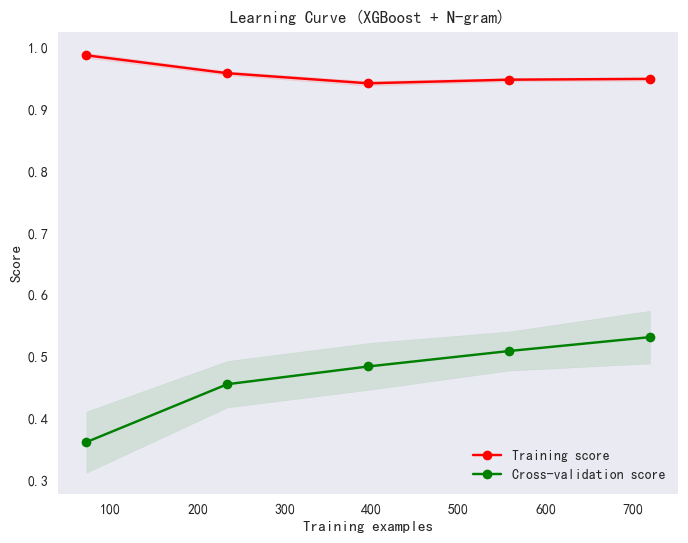


--- Classification Report ---
                         precision    recall  f1-score   support

    Alzheimer's Disease       0.51      0.55      0.53        40
Frontotemporal Dementia       0.51      0.55      0.53        40
     Lewy Body Dementia       0.58      0.47      0.52        40
    Parkinson's Disease       0.70      0.57      0.63        40
      Vascular Dementia       0.56      0.68      0.61        40

               accuracy                           0.56       200
              macro avg       0.57      0.57      0.56       200
           weighted avg       0.57      0.56      0.56       200



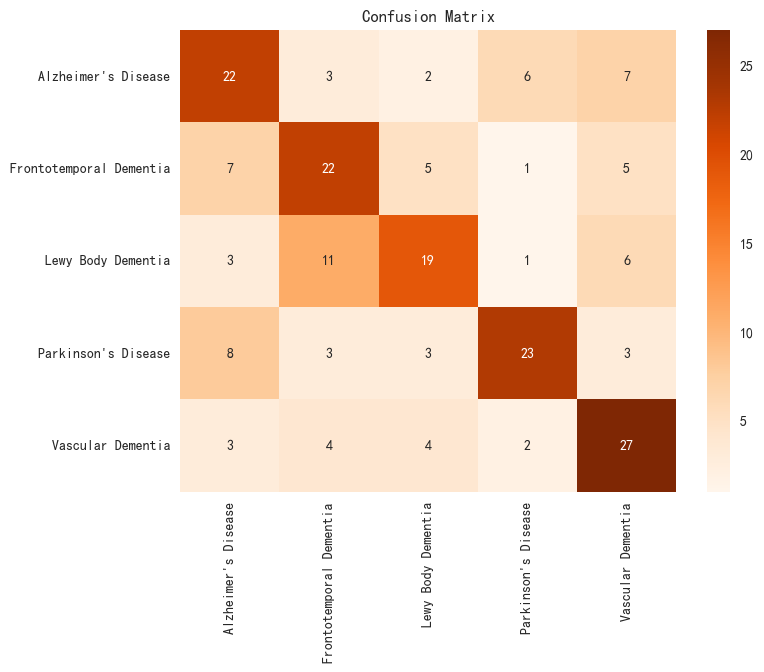

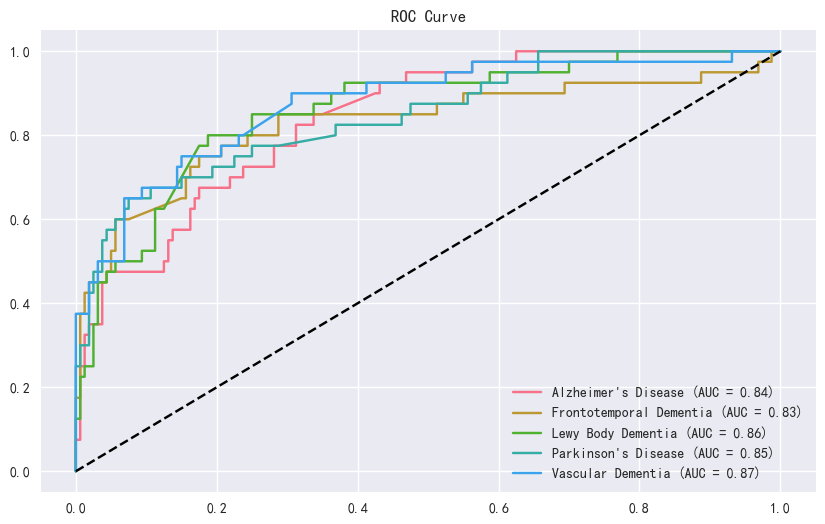


Step 6: Error Analysis...
Top Words in Errors: [('pad', np.int64(1375)), ('disease', np.int64(339)), ('patient', np.int64(43)), ('study', np.int64(40)), ('cognitive', np.int64(32)), ('brain', np.int64(27)), ('tau', np.int64(27)), ('method', np.int64(24)), ('year', np.int64(24)), ('health', np.int64(23)), ('neurodegenerative', np.int64(23)), ('clinical', np.int64(22)), ('protein', np.int64(22)), ('model', np.int64(19)), ('available', np.int64(17)), ('cell', np.int64(17)), ('age', np.int64(16)), ('associated', np.int64(15)), ('based', np.int64(15)), ('using', np.int64(15))]
--- Failure Example ---
True: Lewy Body Dementia | Pred: Frontotemporal Dementia
Text: growing body evidence support use cardiac sympathetic innervation imaging risk stratify patient hear...

Step 7: SHAP Analysis...
SHAP Summary for Class: Alzheimer's Disease


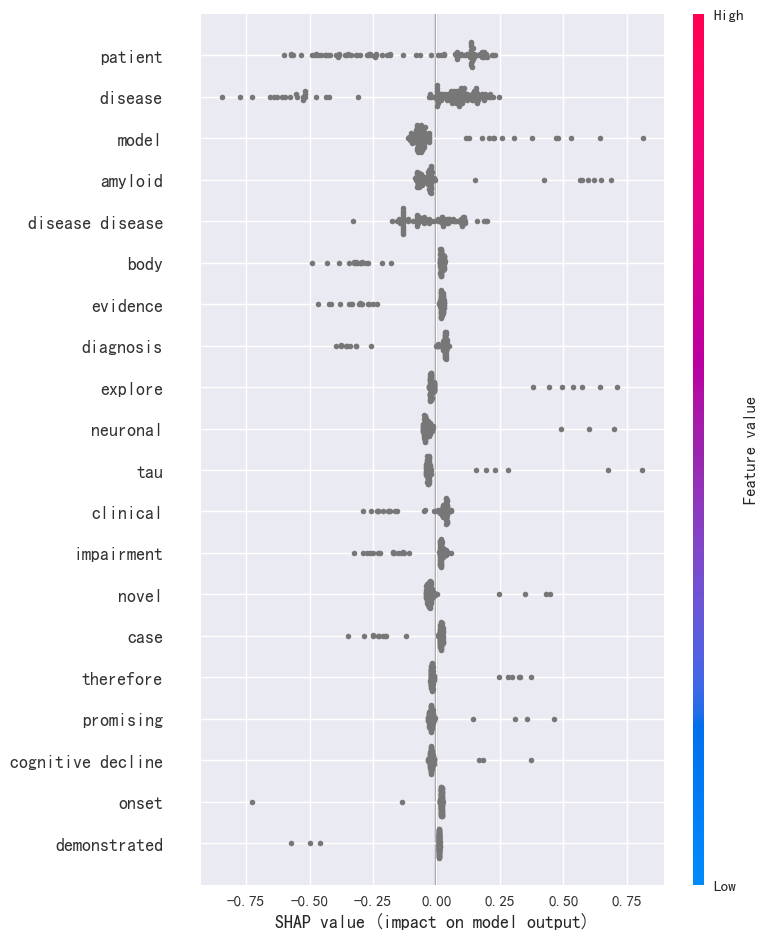

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, learning_curve
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
import shap
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# ==========================================
# 1. 数据加载与预处理 (Data Loading & Preprocessing)
# ==========================================
print("Step 1: Loading Data...")
try:
    df = pd.read_csv('../cleaned_data.csv')
except FileNotFoundError:
    df = pd.read_csv('cleaned_data.csv')

df['Cleaned_Content'] = df['Cleaned_Content'].fillna('')

# 标签编码 (XGBoost 必须使用 0-N 的整数作为标签)
le = LabelEncoder()
df['Label_Encoded'] = le.fit_transform(df['Label'])
label_names = le.classes_
print(f"Classes: {label_names}")

# 划分训练集和测试集
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    df['Cleaned_Content'], df['Label_Encoded'], 
    test_size=0.2, random_state=42, stratify=df['Label_Encoded']
)

# ==========================================
# 2. 特征工程: N-gram (Feature Engineering)
# ==========================================
print("Step 2: Extracting N-gram Features...")
# 使用 CountVectorizer (ngram_range=(1, 2))
# 注意: XGBoost 处理稀疏矩阵效率较高，但 SHAP 可能需要 Dense 或者特定配置
vectorizer = CountVectorizer(ngram_range=(1, 2), max_features=5000)

X_train_features = vectorizer.fit_transform(X_train_raw)
X_test_features = vectorizer.transform(X_test_raw)
feature_names = vectorizer.get_feature_names_out()

print(f"Feature Matrix Shape: {X_train_features.shape}")

# ==========================================
# 3. 模型训练: XGBoost (Training)
# ==========================================
print("\nStep 3: Training XGBoost...")
xgb_model = XGBClassifier(
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=6, 
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42,
    n_jobs=-1
)

# 10-Fold CV
print("Running 10-Fold Cross-Validation...")
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(xgb_model, X_train_features, y_train, cv=cv, scoring='accuracy')

print(f"Mean CV Accuracy: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")

# Train Full Model
xgb_model.fit(X_train_features, y_train)

# ==========================================
# 4. 学习曲线 (Bias vs Variance)
# ==========================================
print("\nStep 4: Plotting Learning Curves...")
def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(8, 6))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()

plot_learning_curve(xgb_model, "Learning Curve (XGBoost + N-gram)", X_train_features, y_train, cv=cv, n_jobs=-1)

# ==========================================
# 5. 评估与可视化
# ==========================================
y_pred = xgb_model.predict(X_test_features)
y_prob = xgb_model.predict_proba(X_test_features)

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred, target_names=label_names))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Oranges',
            xticklabels=label_names, yticklabels=label_names)
plt.title('Confusion Matrix')
plt.show()

plt.figure(figsize=(10, 6))
y_test_bin = pd.get_dummies(y_test).values
if y_test_bin.shape[1] == len(label_names):
    for i, class_label in enumerate(label_names):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_label} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

# ==========================================
# 6. 误差分析 (Error Analysis)
# ==========================================
print("\nStep 6: Error Analysis...")
misclassified_indices = np.where(y_test != y_pred)[0]
if len(misclassified_indices) > 0:
    error_docs = X_test_raw.iloc[misclassified_indices]
    error_cv = CountVectorizer(stop_words='english', max_features=20)
    try:
        error_counts = error_cv.fit_transform(error_docs)
        error_words = error_cv.get_feature_names_out()
        error_word_freq = np.asarray(error_counts.sum(axis=0)).flatten()
        print(f"Top Words in Errors: {sorted(dict(zip(error_words, error_word_freq)).items(), key=lambda x: x[1], reverse=True)}")
    except: pass
    
    print("--- Failure Example ---")
    if len(misclassified_indices) > 0:
        idx = misclassified_indices[0]
        print(f"True: {label_names[y_test.iloc[idx]]} | Pred: {label_names[y_pred[idx]]}")
        print(f"Text: {X_test_raw.iloc[idx][:100]}...")

# ==========================================
# 7. 可解释性 SHAP (Explainability)
# ==========================================
print("\nStep 7: SHAP Analysis...")
try:
    explainer = shap.TreeExplainer(xgb_model)
    # SHAP for XGBoost often returns matrix
    sample_size = min(100, X_test_features.shape[0])
    X_shap_sample = X_test_features[:sample_size]
    shap_values = explainer.shap_values(X_shap_sample)
    
    target_idx = 0 
    # Handle list or array return
    if isinstance(shap_values, list):
         sv = shap_values[target_idx]
    else:
        # XGBoost generally assumes 2D matrix for binary, but list/3D for multiclass
        # In modern SHAP + XGBoost, it might return raw margin values.
        # usually shap_values shape is (samples, features, classes) or list
        if len(np.array(shap_values).shape) == 3:
             sv = shap_values[:, :, target_idx]
        else:
             sv = shap_values
             
    print(f"SHAP Summary for Class: {label_names[target_idx]}")
    shap.summary_plot(sv, X_shap_sample, feature_names=feature_names, show=False)
    plt.show()
except Exception as e:
    print(f"SHAP skipped: {e}")